In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
from scipy.stats import norm
import torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.datasets import load_digits

In [2]:
digits = load_digits()
Data = digits.data

In [3]:
targets = digits.target
targets = torch.from_numpy(targets).long()

In [4]:
Data = torch.from_numpy(Data).float()

In [5]:
def sigma2(t, b_min = 0.1, b_max = 20.0):
  return 1.0 -  torch.exp(-(t*b_min + (t**2)/2*(b_max-b_min)))

def mu(t, b_min = 0.1, b_max = 20.0):
  return torch.exp(-1/2*(t*b_min + (t**2)/2*(b_max-b_min)))

In [6]:
def sample(t, x0, M, b_min = 0.1, b_max = 20.0):
  '''
    #x_0: A matrix (n, d)
    #t: A vector with size (k)
    #
    #return sample of size (n*k*m, d+1)
  '''

  n, d = x0.shape
  k = t.shape[0]
  mean = mu(t).repeat_interleave(n*M)
  var = sigma2(t).repeat_interleave(n*M)
  x0 = x0.repeat(k*M, 1)
  samples = torch.normal(x0 * mean[:, None], torch.sqrt(var)[:, None])
  samples = torch.concatenate((samples, t.repeat_interleave(n*M).unsqueeze(1)), dim = 1)

  return samples


def loss_fn(model, x, b_min = 0.1, b_max = 20.0, M = 30, eps=1e-4, T = 1.0, N = 20):
  step = (T-eps)/N
  t_ = torch.arange(eps, T, step, device = device)
  t_ = torch.concatenate((t_, torch.tensor([1.0], device = device)))

  samples = sample(t_, x, M, b_min = b_min, b_max = b_max)
  t = samples[:, -1].reshape(-1,1)

  x = x.repeat(samples.shape[0]//x.shape[0] ,1)

  mean = x * mu(t, b_min = b_min, b_max = b_max)
  var =  sigma2(t, b_min = b_min, b_max = b_max)
  score = model(samples[:, :-1,], samples[:, -1])
  score_match = -(samples[:, :-1] - mean) / var
  loss = torch.mean(var*(score - score_match)**2)
  return loss

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]

class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        super().__init__()
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                   nn.Linear(embed_dim, embed_dim))
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, padding=1, bias=False)  # Added padding
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, bias=False)  # Added padding
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, bias=False)  # Added padding
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, bias=False)  # Added padding
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1, padding=1)

        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t):
        x = x.reshape(-1, 1, 8, 8)
        embed = self.act(self.embed(t))
        h1 = self.conv1(x)
        h1 += self.dense1(embed)
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h.reshape(h.shape[0], h.shape[2] * h.shape[3])


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

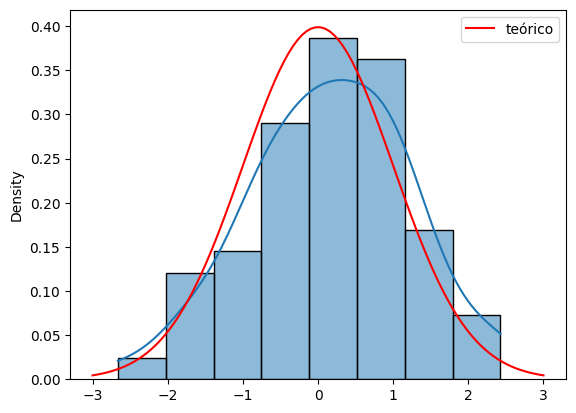

In [ ]:
Noise = sample(torch.ones(500,1).to(device), Data[:500, :].to(device), 1)
sns.histplot(Noise[0,:].cpu().numpy(), stat='density', kde = True)
#y = np.array(1/2*norm.pdf(x,-3,1)) + np.array(1/2*norm.pdf(x,3,1))
x = np.linspace(-3, 3, 100)
y = np.array(norm.pdf(x,0,1))
sns.lineplot(x=x, y=y, color='red', label='teórico')
plt.plot()
del Noise
torch.cuda.empty_cache()

In [ ]:
import pandas as pd
df = pd.DataFrame(Noise[:5, :].T)
sns.pairplot(df, kind="kde")

NameError: name 'Noise' is not defined

In [9]:
from torch.optim import Adam
from torch.utils.data import DataLoader

def score_std(t):
  return torch.sqrt(sigma2(t))

model = ScoreNet(score_std)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


lr = 1e-4
optimizer = Adam(model.parameters(), lr = lr)

In [10]:
batch_size = 8
data_loader = DataLoader(Data, batch_size=batch_size, shuffle=True)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [13]:
#load model
model.load_state_dict(torch.load('/content/drive/MyDrive/TCC/MNISTv4/model_params_MNIST.pth'))

<All keys matched successfully>

In [ ]:
# treino
from tqdm import tqdm
n_epochs = 500
for epoch in tqdm(range(n_epochs), desc="Training Epochs"):
  avg_loss = 0.
  num_items = 0
  for x in data_loader:
    optimizer.zero_grad()
    x = x.to(device)
    loss = loss_fn(model, x, M = 10, N = 150, eps = 1e-6)
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  if epoch % 10 == 0:
    print('epoch:', epoch)
    print('Average Loss: {:5f}'.format(avg_loss / num_items))
    scheduler.step(avg_loss / num_items)
    torch.save(model.state_dict(), '/content/drive/MyDrive/TCC/MNISTv4/model_params_MNIST.pth')

Training Epochs:   0%|          | 1/500 [01:23<11:36:36, 83.76s/it]

epoch: 0
Average Loss: 0.187052


Training Epochs:   2%|▏         | 11/500 [15:18<11:20:07, 83.45s/it]

epoch: 10
Average Loss: 0.183253


Training Epochs:   4%|▍         | 21/500 [29:11<11:05:07, 83.32s/it]

epoch: 20
Average Loss: 0.179736


Training Epochs:   6%|▌         | 31/500 [43:04<10:51:10, 83.31s/it]

epoch: 30
Average Loss: 0.176516


Training Epochs:   8%|▊         | 41/500 [56:57<10:37:55, 83.39s/it]

epoch: 40
Average Loss: 0.173812


Training Epochs:  10%|█         | 51/500 [1:10:52<10:24:03, 83.39s/it]

epoch: 50
Average Loss: 0.170762


Training Epochs:  12%|█▏        | 61/500 [1:24:46<10:09:54, 83.36s/it]

epoch: 60
Average Loss: 0.167672


Training Epochs:  14%|█▍        | 71/500 [1:38:40<9:56:45, 83.46s/it]

epoch: 70
Average Loss: 0.165623


Training Epochs:  15%|█▌        | 77/500 [1:47:11<9:48:50, 83.52s/it]


KeyboardInterrupt: 

In [ ]:
# Salvando os parâmetros do modelo
torch.save(model.state_dict(), '/content/drive/MyDrive/TCC/MNISTv4/model_params_MNIST.pth')

# Salvando o modelo completo
#torch.save(model, 'model_complet_MNIST.pth')

In [14]:
def generate(model, N, d = 100, T = 1, b_min = 0.1, b_max = 20):
  X = torch.randn((d,8*8)).to(device)
  dt = T/N
  eps = 1e-5
  T = T - eps
  def beta(t):
    return b_min + (b_max - b_min)*t
  for i in range(N):
    t = i*T/N
    W = torch.randn((d, 8*8)).to(device)
    xt = torch.cat((X, (1-t)*torch.ones((d,1)).to(device)), dim = 1)
    X = X - (-1/2*beta(T-t)*X - beta(T-t)*model(xt[:, :-1], xt[:, -1]))*dt + np.sqrt(beta(T-t)*dt) * W
  return X

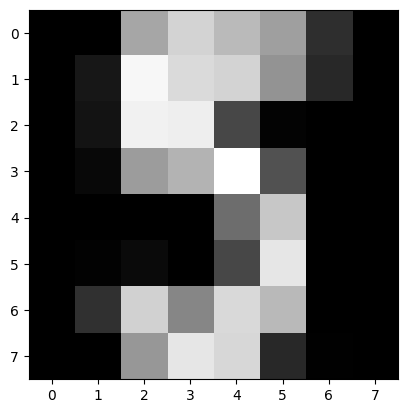

In [15]:
sample_new = generate(model, 1000, d = 1)
sample_new = sample_new[0,:].reshape(8,8).detach().cpu().numpy()
sample_new[sample_new > 16] = 16.
sample_new[sample_new < 0] = 0.
sample_new = sample_new/16
plt.imshow(sample_new, cmap='gray')

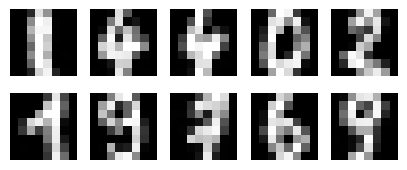

In [19]:
# grid with 10 images
fig, axes = plt.subplots(2, 5, figsize=(5, 2))
for i in range(10):
  sample_new = generate(model, 1000, d = 1)
  sample_new = sample_new[0,:].reshape(8,8).detach().cpu().numpy()
  sample_new[sample_new > 16] = 16.
  sample_new[sample_new < 0] = 0.
  sample_new = sample_new/16
  axes[i//5, i%5].imshow(sample_new, cmap='gray')
  axes[i//5, i%5].axis('off')

In [18]:
from scipy.integrate import solve_ivp
def function_flow(t, x):
  def beta(t):
    b_min = 0.1
    b_max = 20.
    return b_min + (b_max - b_min)*t
  T = 1
  f = -beta(T-t)*x/2
  g2 = beta(T-t)
  model.eval()
  with torch.no_grad():
    xpt = torch.tensor([x]).to(device).float()
    tpt = torch.tensor([T-t]).to(device).float()
    #xt = torch.cat((xpt, tpt), dim = 1)
    score = model(xpt, tpt)
  score = score.detach().cpu().numpy()
  out = f - (g2)*score/2
  return -out

def generate_by_flow_ODE(model, T = 1, b_min = 0.1, b_max = 20):
  model = model
  X = np.random.randn(8*8)
  eps = 1e-5
  sol = solve_ivp(function_flow, [0, T - eps], X, first_step = 1e-5, atol = 1e-5, rtol = 1e-5)
  return sol.y.T

In [ ]:
sample_new = generate_by_flow_ODE(model)

In [29]:
sample_new.shape

(119, 64)

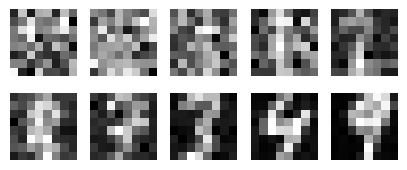

In [31]:
# grid with 10 images
fig, axes = plt.subplots(2, 5, figsize=(5, 2))
for i in range(10):
  sample_ = generate_by_flow_ODE(model)[10*i + 18,:].reshape(8,8)
  axes[i//5, i%5].imshow(sample_ ,cmap='gray')
  axes[i//5, i%5].axis('off')

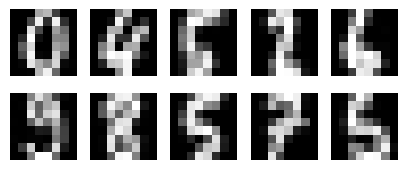

In [25]:
# grid with 10 images
fig, axes = plt.subplots(2, 5, figsize=(5, 2))
for i in range(10):
  sample_new = generate_by_flow_ODE(model)[-1,:].reshape(8,8)
  sample_new[sample_new > 16] = 16.
  sample_new[sample_new < 0] = 0.
  sample_new = sample_new/16
  axes[i//5, i%5].imshow(sample_new, cmap='gray')
  axes[i//5, i%5].axis('off')

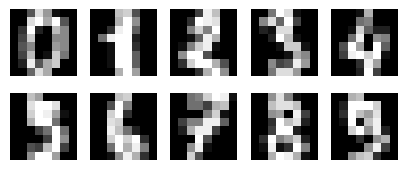

In [24]:
# grid with 10 images
fig, axes = plt.subplots(2, 5, figsize=(5, 2))
for i in range(10):
  sample = Data[i,:].reshape(8,8)
  axes[i//5, i%5].imshow(sample, cmap='gray')
  axes[i//5, i%5].axis('off')

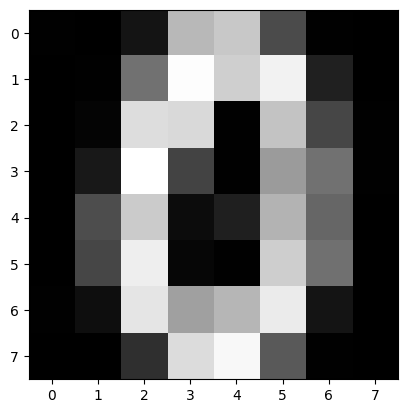

In [48]:
sample_new = generate_by_flow_ODE(model)[-1,:].reshape(8,8)
sample_new[sample_new > 16] = 16.
sample_new[sample_new < 0] = 0.
sample_new = sample_new/16
plt.imshow(sample_new, cmap='gray')

## Condicional

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Random Fourier Features
class RandomFourierFeatures(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RandomFourierFeatures, self).__init__()
        self.B = nn.Parameter(torch.randn(input_dim, output_dim) * 10)
        self.output_dim = output_dim

    def forward(self, x):
        x = torch.matmul(x, self.B)
        x = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
        return x

# WideResNet Basic Block
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        out = self.conv1(out)
        out = F.relu(self.bn2(out))
        out = self.conv2(out)
        out += self.shortcut(x)
        return out

# WideResNet
class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, num_classes):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        n = (depth - 4) // 6
        k = widen_factor

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(16 * k, n, stride=1)
        self.layer2 = self._make_layer(32 * k, n, stride=2)
        self.layer3 = self._make_layer(64 * k, n, stride=2)
        self.bn1 = nn.BatchNorm2d(64 * k)
        self.linear = nn.Linear(64 * k, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Conditional Score Model
class ConditionalScoreModel(nn.Module):
    def __init__(self, num_classes, sigma_dim, fourier_features_dim, depth=22, widen_factor=4):
        super(ConditionalScoreModel, self).__init__()
        self.fourier_features = RandomFourierFeatures(sigma_dim, fourier_features_dim)
        self.wide_resnet = WideResNet(depth, widen_factor, num_classes)

        # Map Fourier features to the same dimension as the output of WideResNet
        self.ff_mapping = nn.Linear(fourier_features_dim * 2, num_classes)

    def forward(self, x, t):
        sigma = sigma2(t)
        x = x.reshape(-1, 1, 8, 8)
        sigma_features = self.fourier_features(sigma)
        out = self.wide_resnet(x)
        sigma_features = self.ff_mapping(sigma_features)
        out = out + sigma_features
        return out


In [35]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(65, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10),
        )

    def forward(self, x, t):
        x = torch.cat((x, t), dim=1)
        logits = self.net(x)
        return logits

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class FourierFeatureTransform(nn.Module):
    def __init__(self, in_features, num_features, scale=10.0):
        super(FourierFeatureTransform, self).__init__()
        self.B = torch.randn((in_features, num_features)) * scale

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B.to(x.device)
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class CustomNeuralNetwork(nn.Module):
    def __init__(self, input1_size, input2_size, num_fourier_features, hidden_size, output_size):
        super(CustomNeuralNetwork, self).__init__()

        # Fourier feature transform for the second input
        self.fourier = FourierFeatureTransform(input2_size, num_fourier_features)

        # Define the network layers
        fourier_output_size = 2 * num_fourier_features  # Since we're concatenating sin and cos outputs
        total_input_size = input1_size + fourier_output_size

        self.fc1 = nn.Linear(total_input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, input1, input2):
        # Apply Fourier feature transform to the second input
        input2 = torch.log(sigma2(input2) + 1e-8)
        input2_transformed = self.fourier(input2)

        # Concatenate the transformed input2 with input1
        x = torch.cat([input1, input2_transformed], dim=-1)

        # Pass through the fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        return output

# Example usage
input1_size = 64
input2_size = 1
num_fourier_features = 32
hidden_size = 256
output_size = 10

classifier = CustomNeuralNetwork(input1_size, input2_size, num_fourier_features, hidden_size, output_size)

# Dummy inputs
input1 = torch.randn(32, input1_size)  # batch size of 32
input2 = torch.randn(32, input2_size)  # batch size of 32

# Forward pass
output = classifier(input1, input2)
print(output.shape)  # Should be [32, 10]


torch.Size([32, 10])


In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class FourierFeatureTransform(nn.Module):
    def __init__(self, in_features, num_features, scale=10.0):
        super(FourierFeatureTransform, self).__init__()
        self.B = torch.randn((in_features, num_features)) * scale

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B.to(x.device)
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class CustomNeuralNetwork(nn.Module):
    def __init__(self, num_fourier_features, hidden_size, output_size):
        super(CustomNeuralNetwork, self).__init__()

        # Fourier feature transform for the second input
        self.fourier = FourierFeatureTransform(1, num_fourier_features)

        # Convolutional layers for the image input
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # 8x8 -> 8x8
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # 8x8 -> 8x8
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 8x8 -> 4x4

        # Fully connected layers
        fourier_output_size = 2 * num_fourier_features  # Since we're concatenating sin and cos outputs
        conv_output_size = 32 * 4 * 4  # After two conv layers and one pooling layer
        total_input_size = conv_output_size + fourier_output_size

        self.fc1 = nn.Linear(total_input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, input1, input2):
        # Apply Fourier feature transform to the second input
        input1 = input1.reshape(input1.shape[0], 1, 8, 8)
        input2 = torch.log(sigma2(input2) + 1e-8)
        input2_transformed = self.fourier(input2)

        # Process input1 through convolutional layers
        x = self.pool(F.relu(self.conv1(input1)))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Concatenate the transformed input2 with the flattened conv output
        x = torch.cat([x, input2_transformed], dim=-1)

        # Pass through the fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        return output

# Example usage
num_fourier_features = 32
hidden_size = 128
output_size = 10

classifier = CustomNeuralNetwork(num_fourier_features, hidden_size, output_size)

# Dummy inputs
input1 = torch.randn(32, 1, 8, 8)  # batch size of 32, 1 channel, 8x8 image
input2 = torch.randn(32, 1)  # batch size of 32

# Forward pass
output = classifier(input1, input2)
print(output.shape)  # Should be [32, 10]


torch.Size([32, 10])


In [113]:
import torch

def sample(t, x0, M, b_min=0.1, b_max=20.0):
    '''
    x0: A matrix (n, d)
    t: A vector with size (k)
    return sample of size (n*k*M, d+1)
    '''
    n, d = x0.shape
    k = t.shape[0]
    mean = mu(t)
    var = sigma2(t)

    mean = mean.repeat_interleave(n * M)
    var = var.repeat_interleave(n * M)
    x0_repeated = x0.repeat(k * M, 1)

    samples = torch.normal(x0_repeated * mean[:, None], torch.sqrt(var)[:, None])
    t_repeated = t.repeat_interleave(n * M).unsqueeze(1)
    samples = torch.cat((samples, t_repeated), dim=1)

    return samples

import torch.nn.functional as F

def loss_fn_class(model_class, x, y, b_min=0.1, b_max=20.0, M=30, eps=0, T=1.0, N=20):
    step = (T - eps) / N
    t_ = torch.arange(eps, T, step, device=x.device)
    t_ = torch.cat((t_, torch.tensor([0.], device=x.device)))

    samples = sample(t_, x, M, b_min=b_min, b_max=b_max)
    t = samples[:, -1].reshape(-1, 1)

    #x_repeated = x.repeat(samples.shape[0] // x.shape[0], 1)
    y_repeated = y.unsqueeze(1).repeat(samples.shape[0] // y.shape[0], 1)

    predict = model_class(samples[:, :-1], t)

    loss = F.cross_entropy(predict, y_repeated.squeeze())
    return loss


In [37]:
#classifier = ConditionalScoreModel(num_classes=10, sigma_dim=1, fourier_features_dim=128)
#classifier = NeuralNetwork()

In [147]:
from torch.optim import Adam
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
classifier = classifier.to(device)

lr = 1e-4
optimizer_class = Adam(classifier.parameters(), lr = lr)

In [148]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64
dataset = TensorDataset(Data, targets)
data_loader_class = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [149]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler_class = ReduceLROnPlateau(optimizer_class, mode='min', factor=0.1, patience=10)

In [120]:
#load model
classifier.load_state_dict(torch.load('/content/drive/MyDrive/TCC/MNISTv4/classifier_params_MNIST.pth'))

RuntimeError: Error(s) in loading state_dict for CustomNeuralNetwork:
	Missing key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias". 
	Unexpected key(s) in state_dict: "embed.0.W", "embed.1.weight", "embed.1.bias", "conv1.weight", "dense1.dense.weight", "dense1.dense.bias", "gnorm1.weight", "gnorm1.bias", "conv2.weight", "dense2.dense.weight", "dense2.dense.bias", "gnorm2.weight", "gnorm2.bias", "conv3.weight", "dense3.dense.weight", "dense3.dense.bias", "gnorm3.weight", "gnorm3.bias", "conv4.weight", "dense4.dense.weight", "dense4.dense.bias", "gnorm4.weight", "gnorm4.bias", "tconv4.weight", "dense5.dense.weight", "dense5.dense.bias", "tgnorm4.weight", "tgnorm4.bias", "tconv3.weight", "dense6.dense.weight", "dense6.dense.bias", "tgnorm3.weight", "tgnorm3.bias", "tconv2.weight", "dense7.dense.weight", "dense7.dense.bias", "tgnorm2.weight", "tgnorm2.bias", "tconv1.weight", "tconv1.bias". 

In [150]:
# treino
from tqdm import tqdm
import gc

n_epochs = 5001
for epoch in tqdm(range(n_epochs), desc="Training Epochs"):
  avg_loss = 0.
  num_items = 0
  for (x,y) in data_loader_class:
    optimizer_class.zero_grad()
    x = x.to(device)
    y = y.to(device)
    loss = loss_fn_class(classifier, x, y, M = 10, N = 150, eps = 0, T = 1)
    loss.backward()
    optimizer_class.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]

  del x, y, loss # Delete tensors after they are used
  gc.collect() # Run garbage collection to free up memory
  torch.cuda.empty_cache() # Empty CUDA cache

  if epoch % 100 == 0:
    print('epoch:', epoch)
    print('Average Loss: {:5f}'.format(avg_loss / num_items))
    scheduler_class.step(avg_loss / num_items)
    torch.save(model.state_dict(), '/content/drive/MyDrive/TCC/MNISTv4/classifier_params_MNIST.pth')

Training Epochs:   0%|          | 1/5001 [00:03<4:16:32,  3.08s/it]

epoch: 0
Average Loss: 2.277424


Training Epochs:   2%|▏         | 101/5001 [05:11<4:11:37,  3.08s/it]

epoch: 100
Average Loss: 0.742906


Training Epochs:   4%|▍         | 201/5001 [10:19<4:06:40,  3.08s/it]

epoch: 200
Average Loss: 0.711297


Training Epochs:   6%|▌         | 301/5001 [15:27<4:01:21,  3.08s/it]

epoch: 300
Average Loss: 0.696882


Training Epochs:   8%|▊         | 401/5001 [20:35<3:58:03,  3.11s/it]

epoch: 400
Average Loss: 0.688394


Training Epochs:  10%|█         | 501/5001 [25:45<3:53:25,  3.11s/it]

epoch: 500
Average Loss: 0.682550


Training Epochs:  12%|█▏        | 601/5001 [30:54<3:47:57,  3.11s/it]

epoch: 600
Average Loss: 0.677525


Training Epochs:  14%|█▍        | 701/5001 [36:03<3:42:57,  3.11s/it]

epoch: 700
Average Loss: 0.674732


Training Epochs:  16%|█▌        | 801/5001 [41:11<3:35:20,  3.08s/it]

epoch: 800
Average Loss: 0.671993


Training Epochs:  18%|█▊        | 901/5001 [46:18<3:30:33,  3.08s/it]

epoch: 900
Average Loss: 0.670210


Training Epochs:  20%|██        | 1001/5001 [51:25<3:25:41,  3.09s/it]

epoch: 1000
Average Loss: 0.671044


Training Epochs:  22%|██▏       | 1101/5001 [56:31<3:19:52,  3.07s/it]

epoch: 1100
Average Loss: 0.665225


Training Epochs:  24%|██▍       | 1201/5001 [1:01:38<3:14:32,  3.07s/it]

epoch: 1200
Average Loss: 0.664619


Training Epochs:  26%|██▌       | 1301/5001 [1:06:45<3:09:23,  3.07s/it]

epoch: 1300
Average Loss: 0.664000


Training Epochs:  28%|██▊       | 1401/5001 [1:11:51<3:04:20,  3.07s/it]

epoch: 1400
Average Loss: 0.662653


Training Epochs:  30%|███       | 1501/5001 [1:16:58<2:59:36,  3.08s/it]

epoch: 1500
Average Loss: 0.661401


Training Epochs:  32%|███▏      | 1601/5001 [1:22:04<2:53:13,  3.06s/it]

epoch: 1600
Average Loss: 0.662254


Training Epochs:  34%|███▍      | 1701/5001 [1:27:12<2:49:21,  3.08s/it]

epoch: 1700
Average Loss: 0.660361


Training Epochs:  36%|███▌      | 1801/5001 [1:32:19<2:43:33,  3.07s/it]

epoch: 1800
Average Loss: 0.661422


Training Epochs:  38%|███▊      | 1901/5001 [1:37:26<2:37:50,  3.06s/it]

epoch: 1900
Average Loss: 0.659898


Training Epochs:  40%|████      | 2001/5001 [1:42:33<2:34:02,  3.08s/it]

epoch: 2000
Average Loss: 0.659106


Training Epochs:  42%|████▏     | 2101/5001 [1:47:40<2:30:15,  3.11s/it]

epoch: 2100
Average Loss: 0.658285


Training Epochs:  44%|████▍     | 2201/5001 [1:52:47<2:23:44,  3.08s/it]

epoch: 2200
Average Loss: 0.657459


Training Epochs:  46%|████▌     | 2301/5001 [1:57:54<2:18:11,  3.07s/it]

epoch: 2300
Average Loss: 0.658178


Training Epochs:  48%|████▊     | 2401/5001 [2:03:01<2:13:43,  3.09s/it]

epoch: 2400
Average Loss: 0.658024


Training Epochs:  50%|█████     | 2501/5001 [2:08:07<2:08:04,  3.07s/it]

epoch: 2500
Average Loss: 0.657468


Training Epochs:  52%|█████▏    | 2601/5001 [2:13:14<2:02:43,  3.07s/it]

epoch: 2600
Average Loss: 0.656885


Training Epochs:  54%|█████▍    | 2701/5001 [2:18:20<1:57:49,  3.07s/it]

epoch: 2700
Average Loss: 0.656274


Training Epochs:  56%|█████▌    | 2801/5001 [2:23:26<1:52:09,  3.06s/it]

epoch: 2800
Average Loss: 0.655587


Training Epochs:  57%|█████▋    | 2846/5001 [2:25:44<1:50:21,  3.07s/it]


KeyboardInterrupt: 

In [151]:
from scipy.integrate import solve_ivp
def function_flow_class(t, x, model, classifier, classe):
  def beta(t):
    b_min = 0.1
    b_max = 20.
    return b_min + (b_max - b_min)*t
  T = 1
  f = -beta(T-t)*x/2
  g2 = beta(T-t)
  model.eval()
  with torch.no_grad():
    xpt = torch.tensor([x]).to(device).float()
    tpt = torch.tensor([T-t]).to(device).float()
    #xt = torch.cat((xpt, tpt), dim = 1)
    score_model = model(xpt, tpt)
    score_class = F.softmax(classifier(xpt, tpt.unsqueeze(0)))[:, classe]
    score = score_model + score_class
  score = score.detach().cpu().numpy()
  out = f - (g2)*score/2
  return -out

def generate_by_flow_ODE_class(model, classifier, classe, T = 1, b_min = 0.1, b_max = 20):
  model = model
  X = np.random.randn(8*8)
  eps = 1e-5
  def function_ode(t, x):
    return function_flow_class(t, x, model, classifier, classe)
  sol = solve_ivp(function_ode, [0, T - eps], X, first_step = 1e-5)
  return sol.y.T

<ipython-input-151-ee4de8e0219f>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_class = F.softmax(classifier(xpt, tpt.unsqueeze(0)))[:, classe]


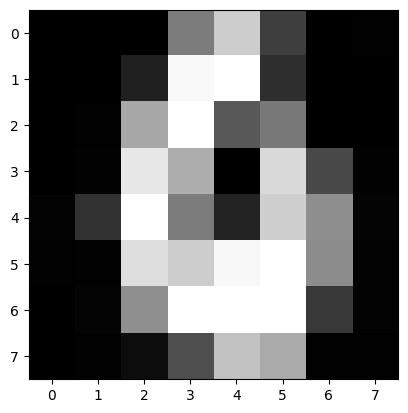

In [154]:
sample_new = generate_by_flow_ODE_class(model, classifier, 7)[-1,:].reshape(8,8)
sample_new[sample_new > 16] = 16.
sample_new[sample_new < 0] = 0.
sample_new = sample_new/16
plt.imshow(sample_new, cmap='gray')